## Demand Planning KPIs and Metrics
- 1- Forecasted vs. actual sales (forecast error).
- 2- Forecast accuracy
- 3- Monthly product category forecast error
- 4- Bias
- 5- Tracking signals
- 6- Mean absolute error (MAE) and mean absolute deviation (MAD)
- 7- Mean absolute percentage error (MAPE)
- 8- Symmetrical mean absolute percentage error (SMAPE)
- 9- Weighted mean absolute percentage error (WMAPE)
- 10- Mean square error (MSE)
- 11- Root mean squared error (RMSE)
- 12- Actual sales conversions vs. sales assumptions
- 13- Order fill rate
- 14- Perfect order rate
- 15- Weekly item location forecast error
- 16- Early warning indicators for demand variation
- 17- Pareto analysis of customer demand
- 18- Prebooking order for new products
- 19- Phase-out products
- 20- Marketing intelligence of competitor activities


# Regression models we will use:
- Linear Regression 
- Ridge Regression 
- Neural Network Regression  
- Lasso Regression  
- Decision Tree Regression  
- Random Forest 
- KNN Model  
- Support Vector Machines (SVM) 
- Gausian Regression 
- Polynomial Regression 

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor,XGBRFRegressor

#load dataset
processed_data= pd.read_csv("processed_data.csv")

# Select features and target variable
features = processed_data.drop(["Number of products sold"],axis=1)
target = processed_data['Number of products sold']

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42)



<AxesSubplot:>

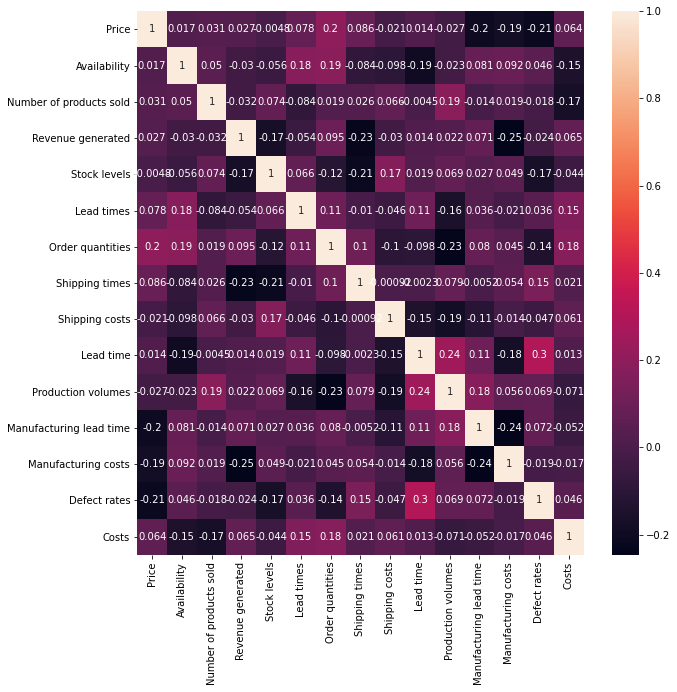

In [5]:
# correlation between features
plt.figure(figsize=(10,10))
import seaborn as sns
sns.heatmap(processed_data.corr(),annot=True)

In [6]:
corr=processed_data.corr().unstack().sort_values(kind='quicksort',ascending=False)
corr=corr[corr!=1]
print(corr[:10])

Defect rates             Lead time                  0.301344
Lead time                Defect rates               0.301344
                         Production volumes         0.243780
Production volumes       Lead time                  0.243780
Order quantities         Price                      0.202017
Price                    Order quantities           0.202017
Number of products sold  Production volumes         0.186606
Production volumes       Number of products sold    0.186606
Availability             Order quantities           0.186327
Order quantities         Availability               0.186327
dtype: float64


<div class="alert alert-block alert-info">
                                  <h1><center>Feature Engineering</center></h1>
</div>

In [7]:
X_train.head(5)

,Product type,SKU,Price,Availability,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,Shipping times,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
68,skincare,SKU98,19.754605,43,8525.952560,Female,53,1,27,7,...,Chennai,28,581,9,5.604691,Pending,2.908122,Rail,Route A,882.198864
30,skincare,SKU42,46.529168,98,1839.609426,Female,22,27,57,4,...,Bangalore,26,179,7,96.422821,Fail,4.939255,Road,Route A,635.657121
57,skincare,SKU75,92.996884,29,1889.073590,Non-binary,16,20,56,10,...,Chennai,25,759,11,48.064783,Pass,2.030069,Air,Route C,873.129648
35,haircare,SKU48,76.035544,28,7397.071005,Non-binary,30,16,9,3,...,Mumbai,9,109,18,23.126364,Fail,1.698113,Rail,Route B,768.651914
56,haircare,SKU74,3.170011,64,5709.945296,Female,41,6,1,5,...,Delhi,1,919,9,80.580852,Fail,0.396613,Rail,Route A,341.552657


In [8]:
# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)



object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['Product type', 'Customer demographics', 'Shipping carriers', 'Supplier name', 'Location', 'Inspection results', 'Transportation modes', 'Routes']

Categorical columns that will be dropped from the dataset: ['SKU']


In [9]:
#apply approach ordinal encoding to object columns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(X_valid[good_label_cols])


print("MAE from Approach (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))


MAE from Approach (Ordinal Encoding):
265.0242857142857


<div class="alert alert-block">
                                  <h1><center>features selection</center></h1>
</div>

In [10]:
# function to measure the mutual information between features and target
from sklearn.feature_selection import  mutual_info_regression
def make_mi_scores(X, y):
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y,discrete_features=discrete_features , random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Location                   0.233367
Manufacturing lead time    0.148556
Inspection results         0.132892
Shipping carriers          0.112878
Shipping times             0.040400
Name: MI Scores, dtype: float64


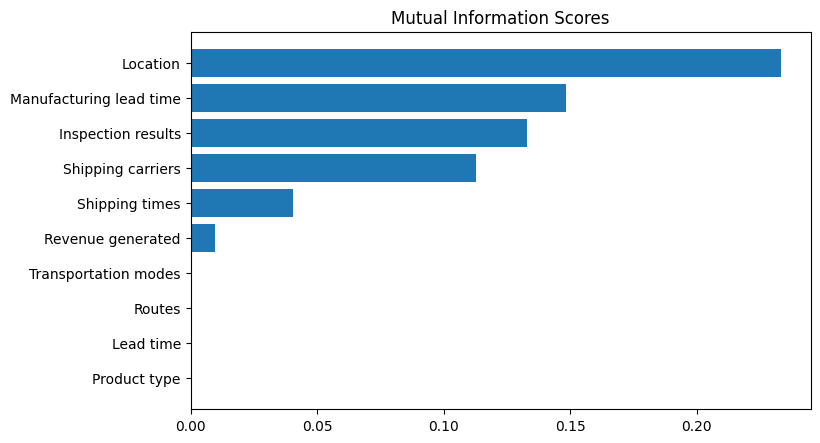

In [11]:
mi_scores= make_mi_scores(label_X_train,y_train)
print(mi_scores.head()) 

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(10))

In [12]:
# insert features from mutual-information & Domain knowledge
my_featrue=['Price', 'Availability', 'Stock levels', 'Order quantities',"Location","Manufacturing lead time", "Inspection results"]

X_train=label_X_train[my_featrue]
X_valid=label_X_valid[my_featrue]

Sc = StandardScaler()
X_train_sc=Sc.fit_transform(X_train)
X_valid_sc=Sc.fit_transform(X_valid)


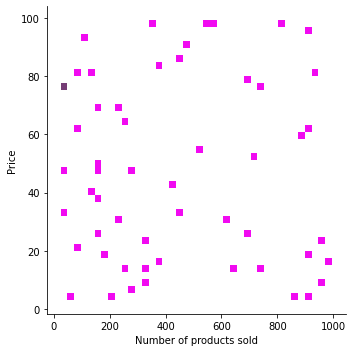

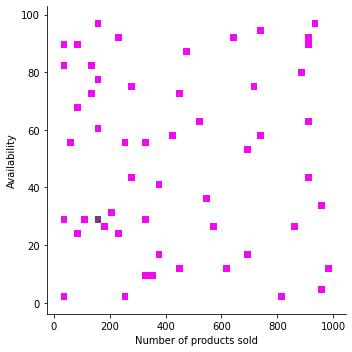

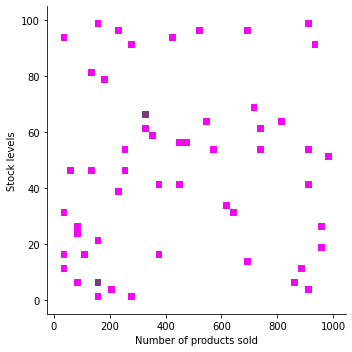

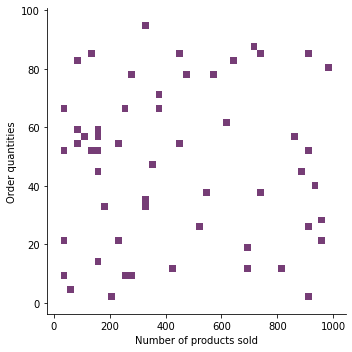

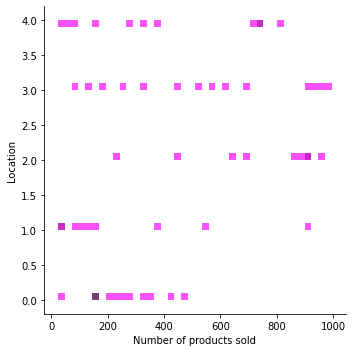

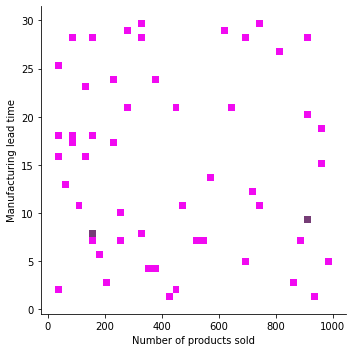

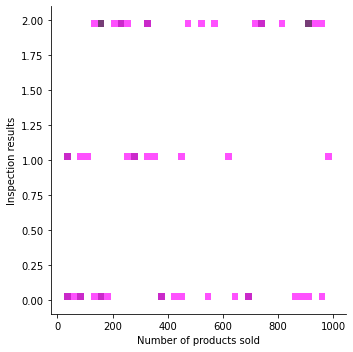

In [13]:
# Draw the values of relationships
def plot_rel_featues():
    for item in my_featrue:
        plo = sns.displot(data=X_train[my_featrue],x=y_train,y=X_train[item], bins=40, color='m')
    return plo
plot_rel_featues()

<div class="alert alert-block">
                                  <h1><center>Model building</center></h1>
</div>

In [15]:
models = {
    "LR": LinearRegression(),
    "KNNR" : KNeighborsRegressor(), 
    "XGBF" : XGBRFRegressor(learning_rate=0.1,n_estimators=100,max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006),
    "XGBR" :  XGBRegressor(),
    "DT": DecisionTreeRegressor(),
    "RF": RandomForestRegressor(n_jobs=-1, n_estimators=100, max_depth=7, random_state=42),
    "LS": Lasso(alpha=0.1)
    
    
}

In [16]:
for name, model in models.items():
    print(f'Using model: {name}')
    model.fit(X_train_sc, y_train)
    y_pred=model.predict(X_valid_sc)
    print(f'Training Score: {model.score(X_train_sc, y_train)}')
    print(f'Test Score: {model.score(X_valid_sc, y_valid)}')
#     print(f'MSE: {model.mean_squared_error(y_test, y_pred)}')
    print('Root MSE:{:,.02f}'.format(np.sqrt(mean_squared_error(y_valid, y_pred))))
    print('MSE:{:,.02f}'.format(mean_squared_error(y_valid, y_pred)))
    print('R2_score:',r2_score(y_valid,y_pred))
    print('-'*30)

Using model: LR
Training Score: 0.12852785391800658
Test Score: -0.16337422059588347
Root MSE:322.76
MSE:104,171.72
R2_score: -0.16337422059588347
------------------------------
Using model: KNNR
Training Score: 0.19140760333653084
Test Score: -0.2721210991649923
Root MSE:337.50
MSE:113,909.21
R2_score: -0.2721210991649923
------------------------------
Using model: XGBF
[13:35:04] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Training Score: -1.524652830242097
Test Score: -2.2735895140111495
Root MSE:541.41
MSE:293,126.17
R2_score: -2.2735895140111495
------------------------------
Using model: XGBR
Training Score: 0.9999999999945016
Test Score: -0.5402386654297244
Root MSE:371.37
MSE:137,917.19
R2_score: -0.5402386654297244
------------------------------
Using model: DT
Training Score: 1.0
Test Score: -0.32656364019986595
Root MSE:344.65
MSE:118,784.14
R2_score: -0.32656364019986595
----

In [19]:

# Linear Regression 
linear_reg = LinearRegression()
linear_reg.fit(X_train_sc, y_train)

# Ridge Regression
ridge_reg = Ridge(alpha=0.001)  
ridge_reg.fit(X_train_sc, y_train)

# Lasso Regression
lasso_reg = Lasso(alpha=0.01)  
lasso_reg.fit(X_train_sc, y_train)

# Decision Tree Regression
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_sc, y_train)

# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_sc, y_train)

# KNN Model
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_sc, y_train)

# Support Vector Machines (SVM)
svm_reg = SVR(kernel='linear', C=1.0)
svm_reg.fit(X_train_sc, y_train)

# Gaussian Regression
gaussian_reg = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10)
gaussian_reg.fit(X_train_sc, y_train)

# Polynomial Regression
degree = 2
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X_train_sc, y_train)

# Neural Network Regression
nn_reg = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=1000, random_state=42)
nn_reg.fit(X_train_sc, y_train)

# Evaluate the models
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_valid_sc)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

# Evaluate each model
print("Linear Regression:")
evaluate(linear_reg, X_valid_sc, y_valid)

print("\nRidge Regression:")
evaluate(ridge_reg, X_valid_sc, y_valid)

print("\nLasso Regression:")
evaluate(lasso_reg, X_valid_sc, y_valid)

print("\nDecision Tree Regression:")
evaluate(tree_reg, X_valid_sc, y_valid)

print("\nRandom Forest:")
evaluate(forest_reg, X_valid_sc, y_valid)

print("\nKNN Model:")
evaluate(knn_reg, X_valid_sc, y_valid)

print("\nSupport Vector Machines (SVM):")
evaluate(svm_reg, X_valid_sc, y_valid)

print("\nGaussian Regression:")
evaluate(gaussian_reg, X_valid_sc, y_valid)

print("\nPolynomial Regression:")
evaluate(poly_reg, X_valid_sc, y_valid)

print("\nNeural Network Regression:")
evaluate(nn_reg, X_valid_sc, y_valid)


Linear Regression:
Mean Squared Error: 104171.71512009653

Ridge Regression:
Mean Squared Error: 104170.93345967043

Lasso Regression:
Mean Squared Error: 104160.82315438487

Decision Tree Regression:
Mean Squared Error: 124803.85714285714

Random Forest:
Mean Squared Error: 96611.96217142859

KNN Model:
Mean Squared Error: 113909.20857142856

Support Vector Machines (SVM):
Mean Squared Error: 109905.14747980016

Gaussian Regression:
Mean Squared Error: 178023.02699832068

Polynomial Regression:
Mean Squared Error: 112559.19378110152

Neural Network Regression:
Mean Squared Error: 161151.01681524125


C:\Users\DELL\anaconda31\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Demand Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Demand= pd.DataFrame({
    "Date":pd.date_range(start="2022-01-01",end="2022-12-31",freq="M"),
    "Demand Forecast": [100,120,110,130,105,125,115,135,120,140,130,150],
    "Actual Sales": [90,110,100,120,95,115,105,125,110,130,120,140],
    "Customer Demand Var": [10,15,12,18,8,14,10,20,15,22,18,25]})

In [12]:
# forecast erorr
Demand["forecast erorr"]= Demand["Actual Sales"]-Demand["Demand Forecast"]

In [11]:
Demand["Demand Forecast"]=Demand["Demand Forecast"]*100

In [13]:
Demand

,Date,Demand Forecast,Actual Sales,Customer Demand Var,forecast erorr
0,2022-01-31,10000,9000,10,-1000
1,2022-02-28,12000,11000,15,-1000
2,2022-03-31,11000,10000,12,-1000
3,2022-04-30,13000,12000,18,-1000
4,2022-05-31,10500,9500,8,-1000
5,2022-06-30,12500,11500,14,-1000
6,2022-07-31,11500,10500,10,-1000
7,2022-08-31,13500,12500,20,-1000
8,2022-09-30,12000,11000,15,-1000
9,2022-10-31,14000,13000,22,-1000


In [35]:
Demand.to_csv(zip=index=False)

'Date,Demand Forecast,Actual Sales,Customer Demand Var,forecast erorr\r\n2022-01-31,10000,9000,10,-1000\r\n2022-02-28,12000,11000,15,-1000\r\n2022-03-31,11000,10000,12,-1000\r\n2022-04-30,13000,12000,18,-1000\r\n2022-05-31,10500,9500,8,-1000\r\n2022-06-30,12500,11500,14,-1000\r\n2022-07-31,11500,10500,10,-1000\r\n2022-08-31,13500,12500,20,-1000\r\n2022-09-30,12000,11000,15,-1000\r\n2022-10-31,14000,13000,22,-1000\r\n2022-11-30,13000,12000,18,-1000\r\n2022-12-31,15000,14000,25,-1000\r\n'

In [38]:
pwd


'E:\\power bi project\\power bi project\\Supply-Chain-Analytics-main\\Dataset'

In [37]:
compression_opts = dict(method='zip',archive_name='Demand.csv') 
Demand.to_csv('out.zip', index=False,compression=compression_opts)

# TEST TIME SERIES 

In [6]:
features.columns

Index(['Product type', 'SKU', 'Price', 'Availability', 'Revenue generated',
       'Customer demographics', 'Stock levels', 'Lead times',
       'Order quantities', 'Shipping times', 'Shipping carriers',
       'Shipping costs', 'Supplier name', 'Location', 'Lead time',
       'Production volumes', 'Manufacturing lead time', 'Manufacturing costs',
       'Inspection results', 'Defect rates', 'Transportation modes', 'Routes',
       'Costs'],
      dtype='object')